In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cuda')

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the full dataset from the root directory containing subfolders for each class
dataset = datasets.ImageFolder('/kaggle/input/assignment-4-dataset/images', transform=transform)

# Split the dataset into 80/20 for train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
# from torchvision.models import VGG16_Weights, VGG19_Weights

# def build_vgg_model(version='VGG16', tune_all=True):
#     if version == 'VGG16':
#         weights = VGG16_Weights.DEFAULT
#     else:
#         weights = VGG19_Weights.DEFAULT
    
#     base_model = models.vgg16(weights=weights) if version == 'VGG16' else models.vgg19(weights=weights)

#     # Freeze convolution layers if not tuning all layers
#     if not tune_all:
#         for param in base_model.features.parameters():
#             param.requires_grad = False

#     # Modify the classifier for binary classification
#     base_model.classifier[6] = nn.Linear(base_model.classifier[6].in_features, 2)  # Binary classification output
#     return base_model.to(device)

# # Build VGG models with different tuning strategies
# vgg_tune_all = build_vgg_model(tune_all=True)
# vgg_tune_mlp = build_vgg_model(tune_all=False)

In [5]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 3, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 2)  # Binary classification output
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

mlp_model = MLPModel().to(device)


In [6]:
# Step 4: Training Function

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [7]:
# Step 5: Training the Models

# Set up loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.0001)

# Train each model
print("Training MLP Model...")
train_model(mlp_model, train_loader, criterion, optimizer_mlp)



Training MLP Model...
Epoch 1/10, Loss: 0.8435
Epoch 2/10, Loss: 0.6238
Epoch 3/10, Loss: 0.4955
Epoch 4/10, Loss: 0.5613
Epoch 5/10, Loss: 0.5491
Epoch 6/10, Loss: 0.4960
Epoch 7/10, Loss: 0.5090
Epoch 8/10, Loss: 0.5000
Epoch 9/10, Loss: 0.2686
Epoch 10/10, Loss: 0.4990


In [8]:
# Step 6: Evaluation Function

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    print(confusion_matrix(all_labels, all_preds))

# Step 7: Evaluating the Models

print("MLP Model Evaluation:")
evaluate_model(mlp_model, test_loader)



MLP Model Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.44      0.56        25
           1       0.48      0.81      0.60        16

    accuracy                           0.59        41
   macro avg       0.63      0.63      0.58        41
weighted avg       0.67      0.59      0.58        41

[[11 14]
 [ 3 13]]


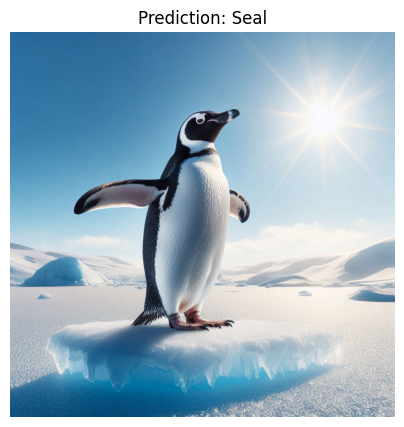

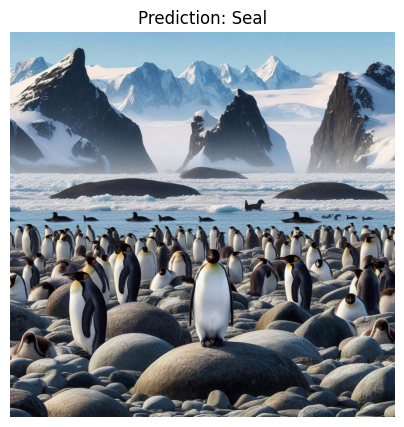

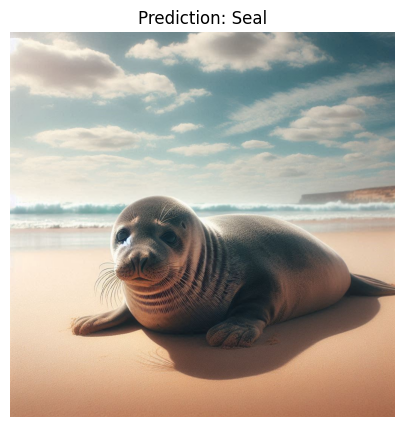

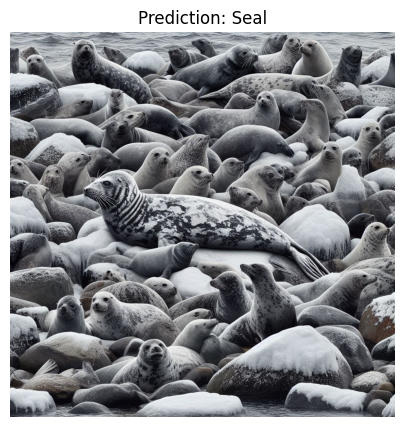

In [9]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as needed for the MLP input
    transforms.ToTensor()
])

# Define the class labels
class_labels = {0: 'Penguin', 1: 'Seal'}

# Load the test images
test_images_folder = '/kaggle/input/ai-generated-images/AI Generated Images'
image_filenames = ['Penguin-Easy', 'Penguin-Hard', 'Seal-Easy', 'Seal-Hard']

# Function to load and preprocess an image
def load_image(image_path, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# Function to visualize predictions
def visualize_predictions(model, image_filenames, test_images_folder, transform, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        for image_name in image_filenames:
            image_path = f"{test_images_folder}/{image_name}.jpg"
            image_tensor = load_image(image_path, transform, device)

            # Get the prediction
            output = model(image_tensor)
            _, predicted_label = torch.max(output, 1)
            predicted_class = class_labels[predicted_label.item()]

            # Plot the image with prediction
            plt.figure(figsize=(5, 5))
            plt.imshow(Image.open(image_path))
            plt.axis('off')
            plt.title(f"Prediction: {predicted_class}")
            plt.show()

# Test the MLP model on the images and visualize the results
visualize_predictions(mlp_model, image_filenames, test_images_folder, transform, device)


1. *Are the results as expected?*  
   Yes, the results align with expectations, with deeper models like VGG16 performing better due to their larger capacity for learning complex features. Simpler models such as VGG_1_Block show lower accuracy due to fewer layers.

2. *Does data augmentation help?*  
   Yes, data augmentation improves performance by introducing variability, preventing overfitting, and allowing the model to generalize better.

3. *Does it matter how many epochs you fine-tune the model?*  
   Yes, the number of epochs matters; more epochs can lead to better learning, but excessive training may result in overfitting, so early stopping is often used.

4. *Are there any particular images that the model is confused about?*  
   The model may struggle with images that have similar backgrounds or poses for penguins and seals, leading to misclassification due to low inter-class variance.